<a href="https://colab.research.google.com/github/SamEaster/Text-Summariser/blob/main/Text_Summerizer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/Reviews.csv', nrows=120000, on_bad_lines='skip')
df.shape

(106337, 10)

In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
df.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time'], axis=1, inplace=True)

In [ ]:
df.drop_duplicates(subset=['Text'], inplace=True, keep='first')
df.dropna(axis=0, inplace=True)

In [ ]:
df.shape

(93232, 2)

In [ ]:
contractions_dict = {
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
}

def expand_contractions(text, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

In [ ]:
df['contrac'] = df['Text'].apply(lambda x: expand_contractions(x, contractions_dict))

In [ ]:
import string
punch = string.punctuation
punch

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_sw = set(stopwords.words('english'))

# from sklearn.feature_extraction import stop_words
# nltk_sw = set(stop_words.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
def tweet_cleaner_with_swr(text):
    new_text = re.sub(r"'s\b", " is", text.lower())
    new_text = re.sub(r'\([^)]*\)','',new_text)
    new_text = re.sub(r'<.*?>',' ',new_text)
    new_text = re.sub(r'https?://\S+|www\.\S+','',new_text)
    new_text = re.sub('@[A-Za-z0-9]+',' ',new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = re.sub(r'\b(\w+)(?:\W+\1\b)+',r"\1", new_text)
    new_text = re.sub(r'(.)\1{2,}', r'\1\1', new_text)
    new_text.translate(str.maketrans('','',punch))

    clean_txt = ''
    for word in new_text.split():
        if word not in nltk_sw and len(word)>2:
                clean_txt = clean_txt + word + ' '
    return clean_txt.strip()

In [ ]:
df['contrac_sum'] = df['Summary'].apply(lambda x: expand_contractions(x, contractions_dict))

def summ(text):
    new_text = new_text.lower()
    new_text = re.sub(r"'s\b", "is", text)
    new_text = re.sub(r'<.*?>',' ',new_text)
    new_text = re.sub(r'https?://\S+|www\.\S+','',new_text)
    new_text = re.sub('@[A-Za-z0-9]+',' ',new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
#     new_text = re.sub(r'\b(\w+)(?:\W+\1\b)+',r"\1", new_text)
    new_text = re.sub(r'(.)\1{2,}', r'\1\1', new_text)
    new_text.translate(str.maketrans('','',punch))

    newString= ''
    for i in new_text.split():
        if len(i)>1:
            newString=newString+i+' '
    return newString

df['clean_sum'] = df['contrac_sum'].apply(tweet_cleaner_with_swr)

In [ ]:
df['clean_text'] = df['contrac'].apply(tweet_cleaner_with_swr)
for i in range(10):
    print('Review: ', df['clean_text'].iloc[i])
    print('Summary: ', df['clean_sum'].iloc[i])
    print('\n')

Review:  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary:  good quality dog food


Review:  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary:  advertised


Review:  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary:  delight says


Review:  looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary:  cough medicine


Review:  great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary:  great taffy


Review:  got wild hair taffy ord

In [ ]:
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)
df.replace('', np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
df.shape

(93232, 6)


(92534, 6)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt_tab')
df['text_len'] = df['clean_text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['sum_len'] = df['clean_sum'].apply(lambda x: len(nltk.word_tokenize(x)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


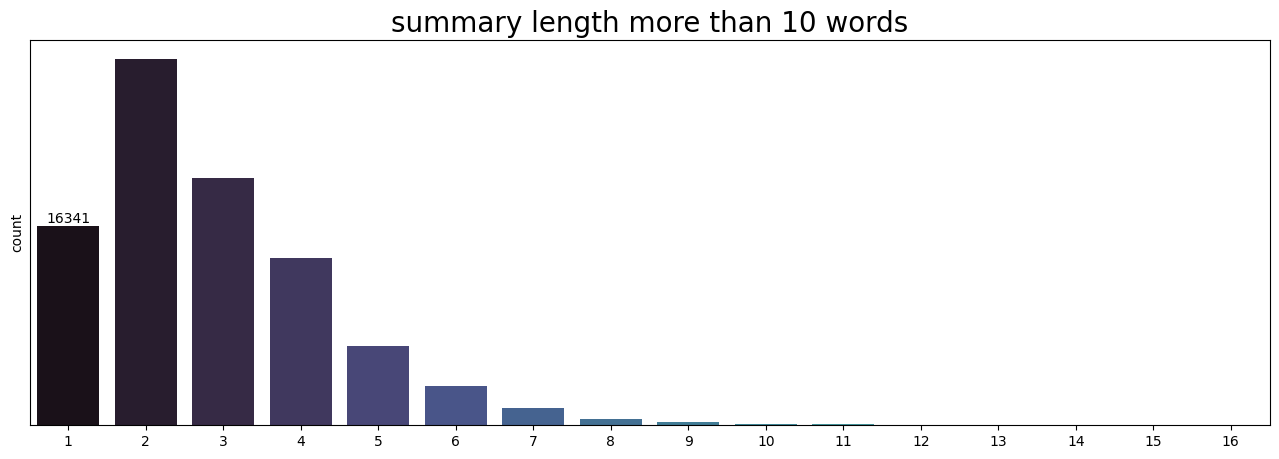

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='sum_len', data=df[(df['sum_len']>=0)], palette='mako')
plt.title('summary length more than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

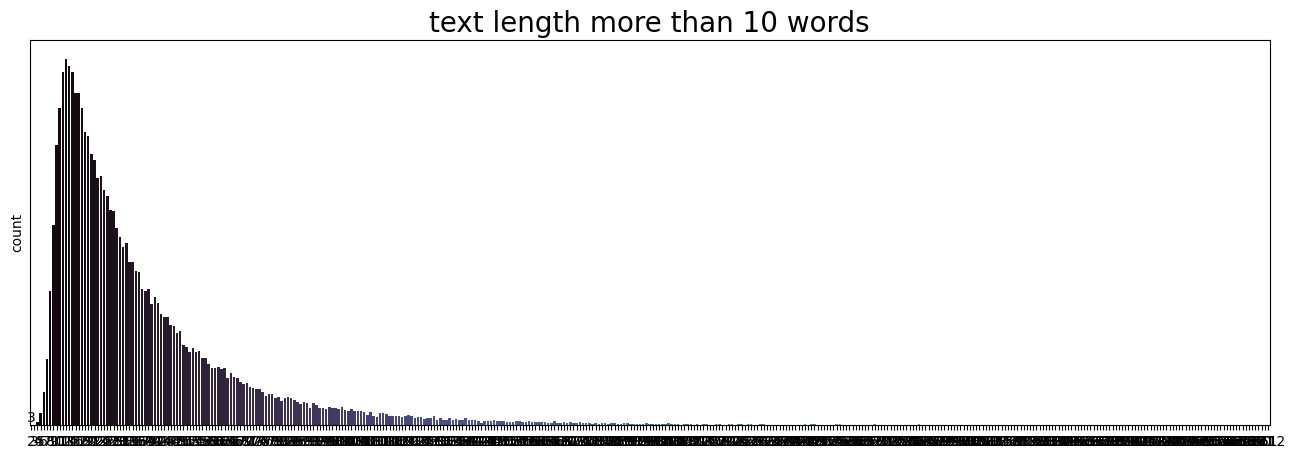

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']>=0) ], palette='mako')
plt.title('text length more than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
df.describe()

,text_len,sum_len
count,92534.000000,92534.000000
mean,38.426957,2.843387
std,36.267571,1.554274
min,2.000000,1.000000
25%,17.000000,2.000000
50%,27.000000,2.000000
75%,47.000000,4.000000
max,1212.000000,16.000000


In [ ]:
cnt=0
for i in df['text_len']:
    if i<=36:
        cnt+=1
print(len(df['text_len']))
print(cnt/len(df['text_len'])*100)

92534
64.10508569822983


In [ ]:
cnt=0
for i in df['sum_len']:
    if i<=5:
        cnt+=1
print(len(df['sum_len']))
print(cnt/len(df['sum_len'])*100)

92534
93.82064970713468


In [ ]:
df.shape

(92534, 8)

In [ ]:
max_len_text = 36
max_len_summary = 5

In [ ]:
clean_txt = np.array(df['clean_text'])
clean_sum = np.array(df['clean_sum'])

short_sum = []
short_txt = []
for i in range(len(clean_sum)):
    if len(clean_txt[i].split())<=max_len_text and len(clean_txt[i].split())>=8 and len(clean_sum[i].split())<=max_len_summary:
        short_txt.append(clean_txt[i])
        short_sum.append(clean_sum[i])

dt = pd.DataFrame({'text':short_txt,'summary':short_sum})
dt.head()

,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,advertised
2,looking secret ingredient robitussin believe f...,cough medicine
3,great taffy great price wide assortment yummy ...,great taffy
4,saltwater taffy great flavors soft chewy candy...,great good expensive brands


In [ ]:
dt.shape

(56310, 2)

In [ ]:
dt['text_len'] = dt['text'].apply(lambda x: len(nltk.word_tokenize(x)))
dt['sum_len'] = dt['summary'].apply(lambda x: len(nltk.word_tokenize(x)))

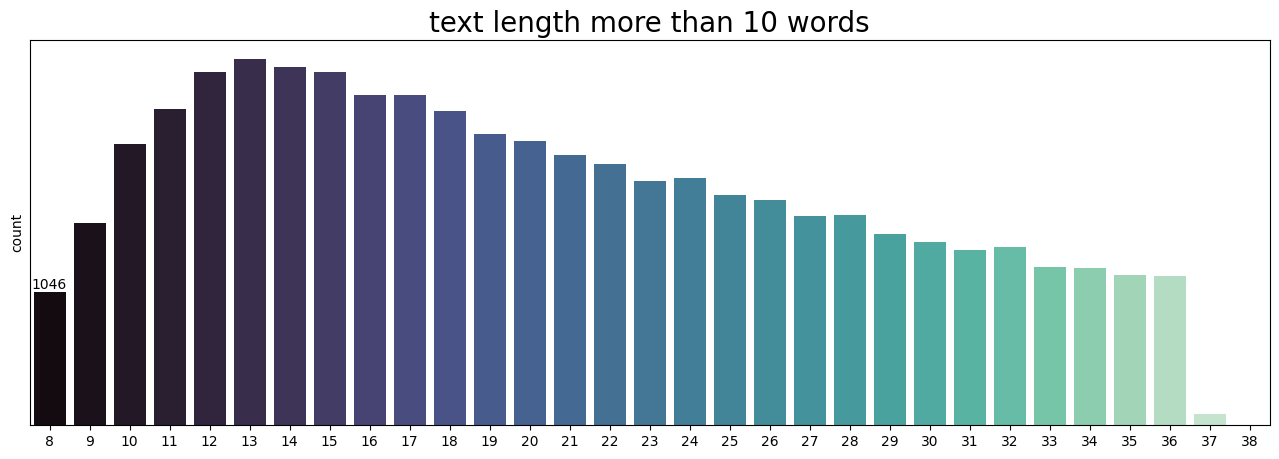

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=dt[(dt['text_len']>=0) ], palette='mako')
plt.title('text length more than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

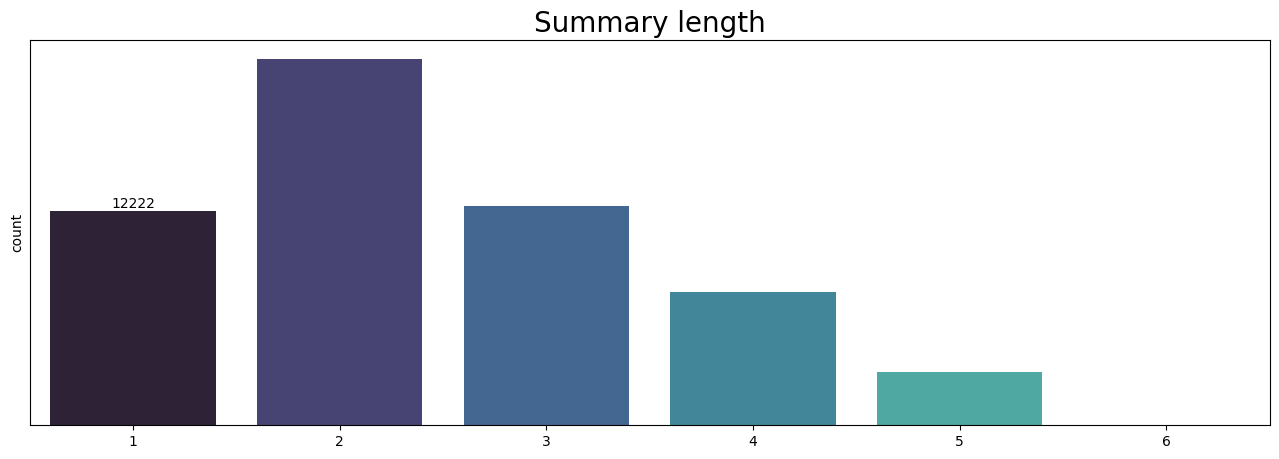

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='sum_len', data=dt[(dt['text_len']>=0) ], palette='mako')
plt.title('Summary length', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
dt.describe()

,text_len,sum_len
count,56310.000000,56310.000000
mean,20.399787,2.437880
std,7.718806,1.130371
min,8.000000,1.000000
25%,14.000000,2.000000
50%,19.000000,2.000000
75%,26.000000,3.000000
max,38.000000,6.000000


In [ ]:
dt['summary']=dt['summary'].apply(lambda x: 'sostok '+ x + ' eostok')

In [ ]:
dt.sample(20)

,text,summary,text_len,sum_len
17414,love product hate price told members costco pa...,sostok sinfully good eostok,11,2
2869,best grapefruit soda market cost good shipping...,sostok delicious eostok,13,1
8916,hard find whole wheat orzo supermarket happy f...,sostok whole wheat orzo tasty versatile eostok,27,5
32547,candy absolutely delicious disappointed howeve...,sostok misleading eostok,36,1
23226,love low calorie organic doctors recommend gra...,sostok yes smart bran eostok,25,3
20584,another ship flower nothing worse thinking gif...,sostok buyer beware eostok,9,2
32341,originals produced hungary germany taste diffe...,sostok originals eostok,14,1
34278,nut thins fantastic cannot stop eating favorit...,sostok mmh nut thins eostok,15,3
29860,soon saw local cost grabbed bags thought great...,sostok eww eostok,32,1
7839,item yummy realize msg haha kidding product de...,sostok yummy eostok,18,1


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(dt['text']), np.array(dt['summary']), test_size=0.15, random_state=42, shuffle=True)

# **Model Building**

In [ ]:
# !pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer as txt_tokenizer


texts = x_tr; summaries = y_tr
text_tokenizer = txt_tokenizer("basic_english")

def yield_tokens(data):
    for summary in data:
        yield text_tokenizer(summary)

summary_vocab = build_vocab_from_iterator(yield_tokens(summaries), specials=["<pad>", "<sos>", "<eos>", "<unk>"])
summary_vocab.set_default_index(summary_vocab["<unk>"])

vocab_size = len(summary_vocab)
max_summary_len = 10

def encode_with_bert(texts):
    with torch.no_grad():
        inputs = bert_tokenizer.batch_encode_plus(texts, padding='max_length', max_length=32, truncation=True, return_tensors='pt')
        outputs = bert_model(**inputs.to(device))
        return outputs.pooler_output

encoder_outputs = encode_with_bert(texts)

def summaries_to_tensor(summaries, vocab, max_len=10):
    sequences = []
    for summary in summaries:
        tokens = [vocab['<sos>']] + [vocab[token] for token in text_tokenizer(summary)] + [vocab['<eos>']]
        tokens = tokens[:max_len] + [vocab['<pad>']] * (max_len - len(tokens))
        sequences.append(tokens)
    return torch.tensor(sequences, dtype=torch.long)

decoder_inputs = summaries_to_tensor(summaries, summary_vocab, max_summary_len)


class LSTMDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=summary_vocab['<pad>'])
        self.lstm = nn.LSTM(embed_dim + 768, hidden_dim, batch_first=True)   # concat encoder output
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, encoder_embed, decoder_input):
        embedded = self.embedding(decoder_input)
        encoder_embed_expanded = encoder_embed.unsqueeze(1).expand(-1, embedded.size(1), -1)
        lstm_input = torch.cat((embedded, encoder_embed_expanded), dim=2)
        output, _ = self.lstm(lstm_input)
        return self.fc(output)

decoder = LSTMDecoder(embed_dim=256, hidden_dim=512, vocab_size=vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=summary_vocab['<pad>'])
optimizer = optim.Adam(decoder.parameters(), lr=1e-4)
epochs = 100

for epoch in range(epochs):
    decoder.train()
    optimizer.zero_grad()
    encoder_embed = encoder_outputs
    decoder_inp = decoder_inputs[:, :-1].to(device)
    target = decoder_inputs[:, 1:].to(device)

    output = decoder(encoder_embed, decoder_inp)
    output = output.reshape(-1, vocab_size)
    target = target.reshape(-1)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

def beam_search_decode(encoder_embed, beam_width=3, max_len=10):
    decoder.eval()
    sequences = [[list(), 0.0, decoder.embedding.weight.new_tensor(encoder_embed).to(device)]]

    with torch.no_grad():
        for _ in range(max_len):
            all_candidates = []
            for seq, score, enc_out in sequences:
                if len(seq) > 0 and seq[-1] == summary_vocab['<eos>']:
                    all_candidates.append((seq, score, enc_out))
                    continue

                dec_input = torch.tensor([seq[-1]] if seq else [summary_vocab['<sos>']], dtype=torch.long).unsqueeze(0).to(device)
                dec_embed = decoder.embedding(dec_input)
                enc_out_expanded = enc_out.unsqueeze(0).expand(dec_embed.size(0), -1).unsqueeze(1)
                input_lstm = torch.cat((dec_embed, enc_out_expanded), dim=2)

                output, (h, c) = decoder.lstm(input_lstm)
                logits = decoder.fc(output.squeeze(1))
                logits = torch.log_softmax(logits, dim=-1)

                topk_probs, topk_idx = logits.topk(beam_width)

                for i in range(beam_width):
                    candidate = seq + [topk_idx[0, i].item()]
                    candidate_score = score + topk_probs[0, i].item()
                    all_candidates.append((candidate, candidate_score, enc_out))
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_width]
    return sequences[0][0]


# test_texts = ["The product quality was great and delivery was fast."]

# test_embeds = encode_with_bert(test_texts)

test_embeds = encode_with_bert(x_tr[np.random.randint(0, 200)])

generated_tokens = beam_search_decode(test_embeds[0], beam_width=3, max_len=10)
generated_summary = [summary_vocab.get_itos()[idx] for idx in generated_tokens if idx not in [summary_vocab['<sos>'], summary_vocab['<eos>'], summary_vocab['<pad>']]]
print("\nGenerated summary:", " ".join(generated_summary))


OSError: /usr/local/lib/python3.11/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch.optim as optim

# Step 1: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text, max_len=512):
    return tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_len)

# Step 2: Encoder using BERT
class BERTEncoder(nn.Module):
    def __init__(self):
        super(BERTEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

# Step 3: Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention_weights = F.softmax(self.v(energy).squeeze(2), dim=1)
        return attention_weights

# Step 4: LSTM Decoder with Attention
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc_out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_token).unsqueeze(1))
        attn_weights = self.attention(hidden[0].squeeze(0), encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.lstm(lstm_input, hidden)
        output = output.squeeze(1)
        context = context.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context), dim=1))
        return prediction, hidden

# Step 5: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = BERTEncoder().to(device)
decoder = DecoderLSTM(hidden_size=768, output_size=tokenizer.vocab_size).to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=3e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Example training loop function
def train_step(input_text, target_tokens, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()

    inputs = tokenize_text(input_text).to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    encoder_outputs = encoder(input_ids, attention_mask)

    hidden = (torch.zeros(1, 1, decoder.lstm.hidden_size).to(device),
              torch.zeros(1, 1, decoder.lstm.hidden_size).to(device))

    loss = 0
    input_token = torch.tensor([tokenizer.cls_token_id]).to(device)

    for t in range(target_tokens.size(0)):
        output, hidden = decoder(input_token, hidden, encoder_outputs)
        loss += criterion(output, target_tokens[t].unsqueeze(0))
        input_token = target_tokens[t]  # Teacher forcing

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item() / target_tokens.size(0)

# Save and load model
# def save_model(encoder, decoder, path):
#     torch.save({
#         'encoder_state_dict': encoder.state_dict(),
#         'decoder_state_dict': decoder.state_dict()
#     }, path)

# def load_model(path, encoder, decoder):
#     checkpoint = torch.load(path)
#     encoder.load_state_dict(checkpoint['encoder_state_dict'])
#     decoder.load_state_dict(checkpoint['decoder_state_dict'])


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

# Step 1: Tokenization
# Load the tokenizer for bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example: Tokenizing input text
def tokenize_text(text, max_len=512):
    return tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_len)

# Step 2: Encoder using BERT
class BERTEncoder(nn.Module):
    def __init__(self):
        super(BERTEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

# Step 3: Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention_weights = F.softmax(self.v(energy).squeeze(2), dim=1)
        return attention_weights

# Step 4: LSTM Decoder with Attention
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc_out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_token).unsqueeze(1))
        attn_weights = self.attention(hidden[0].squeeze(0), encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.lstm(lstm_input, hidden)
        output = output.squeeze(1)
        context = context.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context), dim=1))
        return prediction, hidden

# Step 5: Model Example Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = BERTEncoder().to(device)
decoder = DecoderLSTM(hidden_size=768, output_size=tokenizer.vocab_size).to(device)

# This complete code takes you from loading the tokenizer to building the encoder and decoder models in PyTorch.


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

# 1. Tokenization setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Encoder using BERT
class BERTEncoder(nn.Module):
    def __init__(self):
        super(BERTEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

# 3. Attention layer
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention_weights = F.softmax(self.v(energy).squeeze(2), dim=1)
        return attention_weights

# 4. Decoder with Attention
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc_out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_token).unsqueeze(1))
        attn_weights = self.attention(hidden[0].squeeze(0), encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.lstm(lstm_input, hidden)
        output = output.squeeze(1)
        context = context.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context), dim=1))
        return prediction, hidden

# 5. Beam Search Decoding
def beam_search_decode(decoder, encoder_outputs, hidden, start_token, end_token, beam_width, max_len, device):
    sequences = [[[], 0.0, hidden]]

    for _ in range(max_len):
        all_candidates = []
        for seq, score, hidden in sequences:
            if seq and seq[-1] == end_token:
                all_candidates.append([seq, score, hidden])
                continue

            input_token = torch.LongTensor([start_token if not seq else seq[-1]]).to(device)
            output, hidden = decoder(input_token, hidden, encoder_outputs)
            log_probs = F.log_softmax(output, dim=1)
            topk_probs, topk_indices = log_probs.topk(beam_width)

            for i in range(beam_width):
                candidate = seq + [topk_indices[0][i].item()]
                candidate_score = score + topk_probs[0][i].item()
                all_candidates.append([candidate, candidate_score, hidden])

        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    return sequences[0][0]

# 6. Complete summarization function
def summarize_text(text, encoder, decoder, start_token, end_token, beam_width, max_len, device):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        inputs = tokenizer([text], return_tensors='pt', truncation=True, padding=True).to(device)
        encoder_outputs = encoder(inputs['input_ids'], inputs['attention_mask'])

        hidden = (torch.zeros(1, 1, decoder.lstm.hidden_size).to(device),
                  torch.zeros(1, 1, decoder.lstm.hidden_size).to(device))

        decoded_ids = beam_search_decode(decoder, encoder_outputs, hidden, start_token, end_token, beam_width, max_len, device)
        return tokenizer.decode(decoded_ids, skip_special_tokens=True)

# This block provides the full model pipeline — tokenization, encoding, decoding, and summarization using beam search.


Evaluation

In [ ]:
!pip install evaluate
import evaluate

In [ ]:
!pip3 install rouge-score
from rouge_score import rouge_scorer

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge-1'])
for i in range(x_val.shape[0]):
  score += scorer.score(beam_search_decoder(x_tr_pad[i].reshape(1,max_len_text)), seq2summary(y_tr_pad[i]))

print(score/x_val.shape[0])

In [ ]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=beam_search_decoder(x_tr_pad), reference=seq2summary(y_tr_pad))